---
**Turma:** 15

**Grupo:** 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`


**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

---
# Regressão Logistica

In [0]:
root_dir = '/dbfs/FileStore/ifood'

dbutils.fs.ls(f'{root_dir}')

Out[1]: [FileInfo(path='dbfs:/dbfs/FileStore/ifood/abt/', name='abt/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/customer_segmentation/', name='customer_segmentation/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/enrich/', name='enrich/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/marketing_push_full/', name='marketing_push_full/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders/', name='orders/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders_with_cost_revenue/', name='orders_with_cost_revenue/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/preprocess/', name='preprocess/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/sessions_visits/', name='sessions_visits/', size=0)]

### Load ABT Train Test

In [0]:
abt = 'abt_case_aug_half_end'

df_abt_case_train = spark.read.parquet(
  f'{root_dir}/abt/{abt}_train'
).repartition(2).cache()
df_abt_case_train.createOrReplaceTempView(f'{abt}_train')
df_abt_case_train.createOrReplaceTempView('abt_train')

df_abt_case_test = spark.read.parquet(
  f'{root_dir}/abt/{abt}_test'
).repartition(2).cache()
df_abt_case_test.createOrReplaceTempView(f'{abt}_test')
df_abt_case_test.createOrReplaceTempView('abt_test')

df_abt_case_train.count(), df_abt_case_test.count()

Out[2]: (21036, 9043)

### VectorAssembler

In [0]:
from pyspark.ml.feature import VectorAssembler

featureList = [
  'orders_last_91d',
  'qtt_valid_orders',
  'qtt_invalid_orders',
  'customer_lifetime_days',
  'rfv_score',
  'merchant_variety',
  'merchant_offer',
  'total_send',
  'total_bounce',
  'total_click',
  'sum_event_open',
  'label_last_month'
]

assembler = VectorAssembler(inputCols=featureList, outputCol = 'features')

dfAssemblerTrain = assembler.transform(df_abt_case_train)
dfAssemblerTest  = assembler.transform(df_abt_case_test)

# GridSearch

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier

estimator = RandomForestClassifier(seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(estimator.numTrees, [10, 30])\
    .addGrid(estimator.maxDepth, [4, 6])\
    .addGrid(estimator.featureSubsetStrategy, ['4', '5', 'auto'])\
    .build()

evaluator = BinaryClassificationEvaluator()
evaluator.setMetricName("areaUnderROC")

crossval = CrossValidator(
  estimator=estimator,
  estimatorParamMaps=paramGrid,
  evaluator=evaluator,
  parallelism=3,
  numFolds=3
)

# Deve demorar de 2 a 3 minutos
import time

dfAssemblerTrain.cache()

ti = time.time()
cvModel = crossval.fit(dfAssemblerTrain)
tf = time.time()

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
tf - ti

Out[80]: 125.75912404060364

In [0]:
import pandas as pd

pdSummaryParam = pd.DataFrame(cvModel.getEstimatorParamMaps())
pdSummaryParam['avgMetrics'] = cvModel.avgMetrics
pdSummaryParam.columns = ['numTrees', 'maxDepth', 'featureSubsetStrategy', 'underROC']

pdSummaryParam.sort_values('underROC', ascending=False)

,numTrees,maxDepth,featureSubsetStrategy,underROC
11,30,6,auto,0.938448
9,30,6,4,0.938448
10,30,6,5,0.938243
4,10,6,5,0.938176
8,30,4,auto,0.938021
6,30,4,4,0.938020
7,30,4,5,0.937935
3,10,6,4,0.937371
5,10,6,auto,0.937371
2,10,4,auto,0.936860


### Evaluation on Test

In [0]:
dfCvPrediction = cvModel.transform(dfAssemblerTest)

In [0]:
from sklearn.metrics import classification_report 
import pandas as pd
pd.set_option('display.precision', 6)

pdCvReport = dfCvPrediction.select('label', 'prediction').toPandas()

#### Metric ROC PR

In [0]:
import pandas as pd

evaluator = BinaryClassificationEvaluator()

pdCvMetric = pd.DataFrame({
  "areaUnderROC": [evaluator.setMetricName("areaUnderROC").evaluate(dfCvPrediction)],
  "areaUnderPR": [evaluator.setMetricName("areaUnderPR").evaluate(dfCvPrediction)]
})

pdCvMetric.transpose()

,0
areaUnderROC,0.941310
areaUnderPR,0.901806


In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
            
        # Separa em FPR e TPR
        fpr = []
        tpr = []
        for f, t in points:
          fpr.append(f)
          tpr.append(t)
        
        return fpr, tpr

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

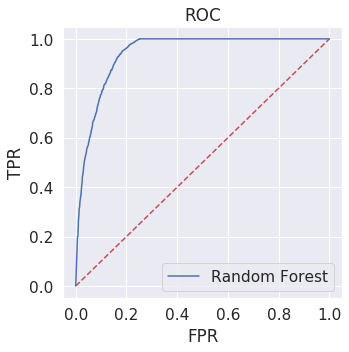

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0.0, 1.0], 'r--')

# Computa as previsões e recupera o alvo e as probabilidades em RDD
preds = dfCvPrediction.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Retorna duas lista com FPR e TPR (FPR - false positive rate, TPR - true positive rate)
fpr, tpr = CurveMetrics(preds).get_curve('roc')
plt.plot(fpr, tpr, label='Random Forest')

plt.title('ROC')
plt.legend(loc="best")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Classification Report

In [0]:
pd.DataFrame(
  classification_report(pdCvReport['label'], pdCvReport['prediction'], output_dict=True)
)

,0,1,accuracy,macro avg,weighted avg
precision,0.951007,0.802353,0.874157,0.876680,0.885828
recall,0.818039,0.946028,0.874157,0.882033,0.874157
f1-score,0.879526,0.868287,0.874157,0.873906,0.874598
support,5078.000000,3965.000000,0.874157,9043.000000,9043.000000


#### Confussion Matrix

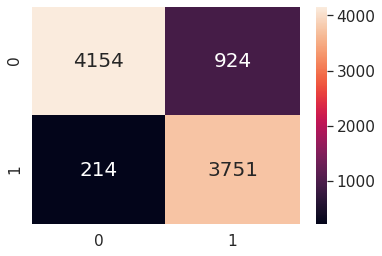

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pdCvMatrix = dfCvPrediction.select('label', 'prediction').toPandas()

cm = confusion_matrix(pdCvMatrix['label'], pdCvMatrix['prediction'])

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='g')

In [0]:
dfCvPrediction.select('label', 'label_last_month')

Out[89]: DataFrame[label: int, label_last_month: int]

In [0]:
import pandas as pd
import numpy as np

pdCoef = pd.DataFrame()
pdCoef['column'] = featureList
pdCoef['importance'] = list(cvModel.bestModel.featureImportances)
#pdCoef['Intercept'] = model.stages[-1].intercept

pdCoef.sort_values(by='importance', ascending=False)

,column,importance
10,sum_event_open,0.647438
11,label_last_month,0.127692
7,total_send,0.066872
0,orders_last_91d,0.059180
1,qtt_valid_orders,0.051672
5,merchant_variety,0.023379
3,customer_lifetime_days,0.014622
2,qtt_invalid_orders,0.004644
4,rfv_score,0.002326
9,total_click,0.001009


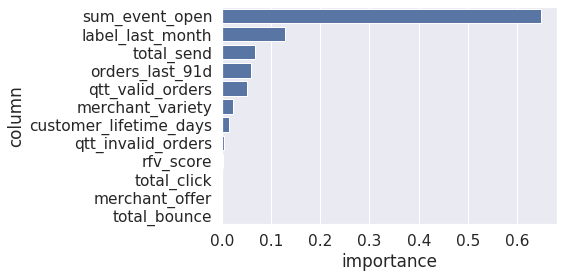

In [0]:
sns.barplot(x='importance',y='column', data=pdCoef.sort_values(by='importance', ascending=False), color="b")